In [1]:
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

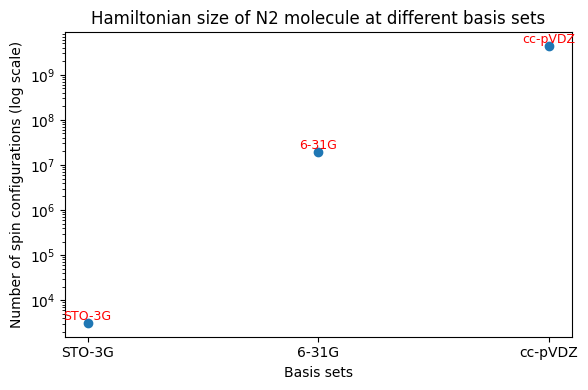

In [2]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

In [3]:
# Exercise 1: Number of possible spin configurations
# Example: O2 molecule in 6-31G basis
# 16 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate all valid electron configurations
# Hint: This is a combinatorial problem. You can calculate by hand and provide the answer or use the math.comb() method below.

# ---- TODO : Task 1 ---
### Provide your code below to calculate the total configurations

α_config = comb(16,7)
β_config = comb(16,5)
total_config = (α_config)*(β_config)
# --- End of TODO ---

print(f"Total physical configurations for O2 in the given basis : {α_config:} x {β_config:} = {total_config}")

Total physical configurations for O2 in the given basis : 11440 x 4368 = 49969920


In [4]:
# Submit your answer using following code

grade_lab3_ex1(total_config) # Expected result type: integer

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [5]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383187  S^2 = 0.0000000


In [6]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929732  E_corr = -0.2045891221988309


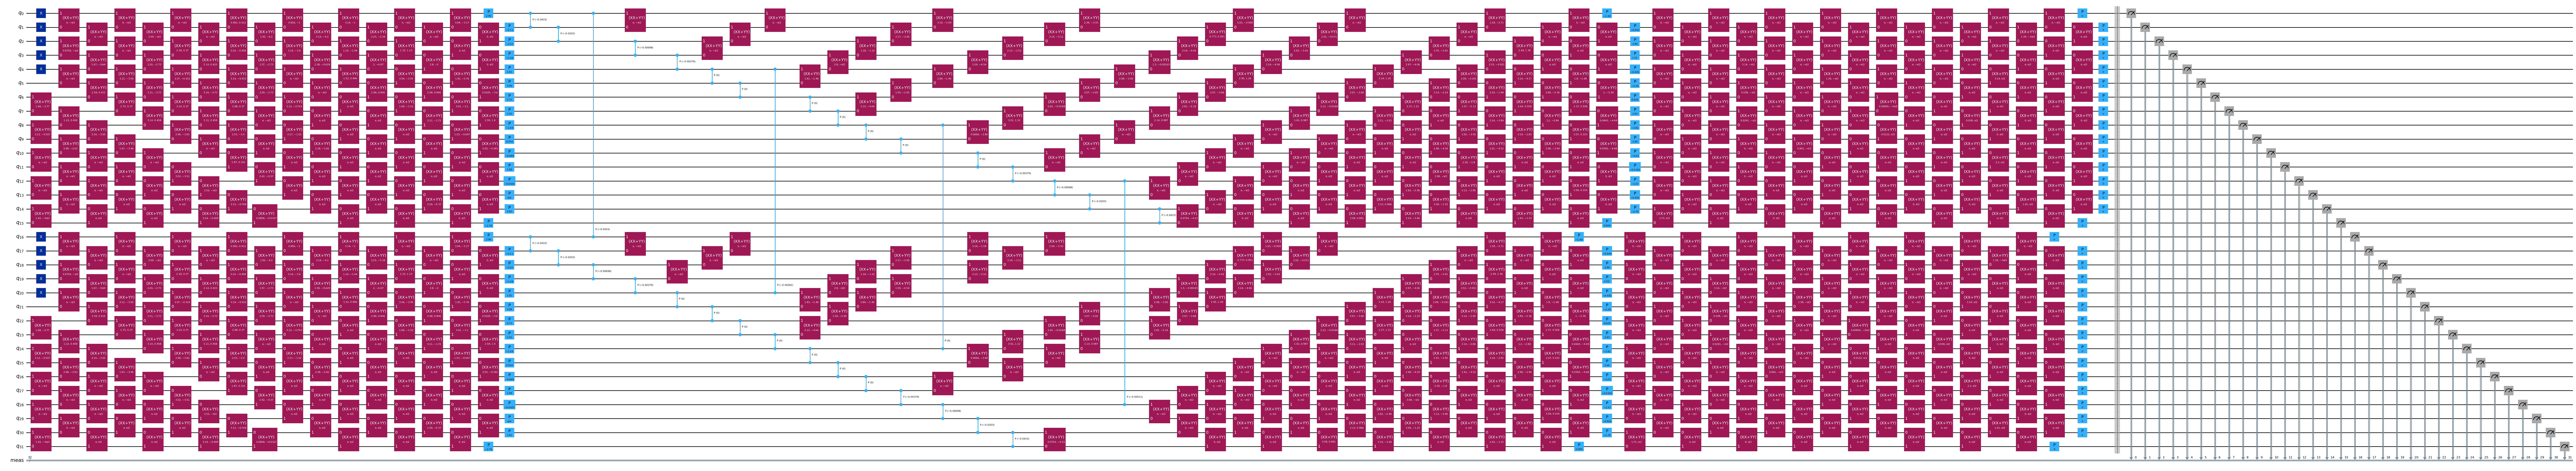

In [7]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

circuit.decompose().decompose().draw("mpl", fold =-1)

In [8]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")

In [9]:
spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/ pre-init passes): OrderedDict([('rz', 2445), ('sx', 2143), ('ecr', 730), ('x', 80), ('measure', 32), ('barrier', 1)])


In [10]:
bit_array = np.load('N2_device_bitarray.npy', allow_pickle=True).item()

In [11]:
%%time
# SQD options
energy_tol = 1e-3  
occupancies_tol = 1e-3 
max_iterations = 5

# Eigenstate solver options
num_batches = 5
samples_per_batch = 50
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200
rng = np.random.default_rng(24)


# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -106.273290131417
		Subspace dimension: 10000
	Subsample 1
		Energy: -105.43810831755859
		Subspace dimension: 9801
	Subsample 2
		Energy: -106.63769425969387
		Subspace dimension: 10000
	Subsample 3
		Energy: -106.61258013830124
		Subspace dimension: 9801
	Subsample 4
		Energy: -106.63164450395635
		Subspace dimension: 9801
Iteration 2
	Subsample 0
		Energy: -107.9108490741182
		Subspace dimension: 9409
	Subsample 1
		Energy: -108.84006034736294
		Subspace dimension: 9604
	Subsample 2
		Energy: -108.84150457670017
		Subspace dimension: 10000
	Subsample 3
		Energy: -107.91290084871598
		Subspace dimension: 9409
	Subsample 4
		Energy: -108.84031227231542
		Subspace dimension: 9216
Iteration 3
	Subsample 0
		Energy: -108.89577578545783
		Subspace dimension: 12769
	Subsample 1
		Energy: -108.87738057039101
		Subspace dimension: 12769
	Subsample 2
		Energy: -108.8824313957169
		Subspace dimension: 12321
	Subsample 3
		Energy: -108.86232234859592
		Subspac

Exact energy: -109.04667 Ha
SQD energy: -108.96882 Ha
Absolute error: 0.07785 Ha


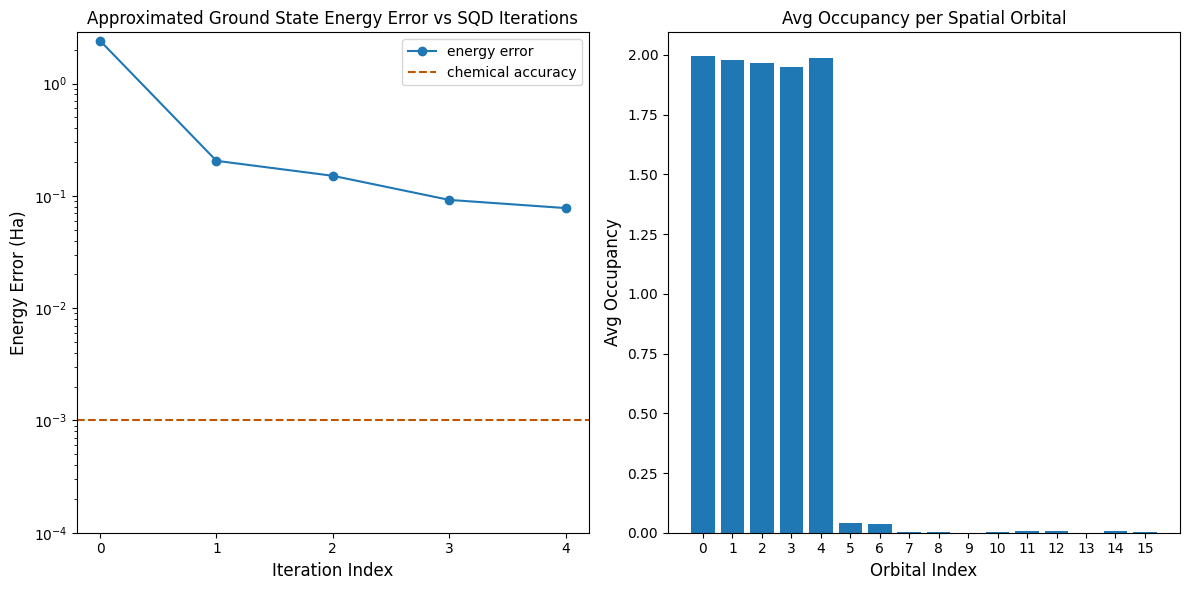

In [12]:
def plot_energy_and_occupancy(result_history, exact_energy):

    # Data for energies plot
    x1 = range(len(result_history))
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
    
    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001
    
    # Data for avg spatial orbital occupancy
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot energies
    axs[0].plot(x1, e_diff, label="energy error", marker="o")
    axs[0].set_xticks(x1)
    axs[0].set_xticklabels(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yticklabels(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()

    # Plot orbital occupancy
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
    
    print(f"Exact energy: {exact_energy:.5f} Ha")
    print(f"SQD energy: {min_e[-1]:.5f} Ha")
    print(f"Absolute error: {e_diff[-1]:.5f} Ha")
    plt.tight_layout()
    plt.show()

plot_energy_and_occupancy(result_history, exact_energy)

In [29]:
n = [0.007, 0.029, 0.029, 0.995, 
     0.976, 0.976, 0.993, 0.997, 
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]

x = [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]

x = np.array(x)
n = np.array(n)

halfx = int(len(x)/2)
halfy = int(len(y)/2)

# ---- TODO : Task 2 ---

# Divide into alpha spin and beta spin
x_alpha = x[(-halfx):]
x_beta = x[:(halfx)]

# probability of flipping
y = np.abs(x - n)
y_alpha = y[-(halfy):]
y_beta = y[:(halfy)]

# In this case, one more beta particle is needed, so set y_beta[i] to 0 if x_beta[i] is already 1, as there are only 4 1s in the first half, instead of 5 
for i in range(len(y_beta)):
    if x_beta[i] == 1:
        y_beta[i] = 0
    
# --- End of TODO ---

print(y_beta)

[0.    0.029 0.029 0.995 0.    0.976 0.    0.   ]


In [30]:
h = 5/8
delta = 0.01
w = np.zeros(len(y_beta))

# find the maximum w
# ---- TODO : Task 2 ---
for i in range(len(y_beta)):
    if y_beta[i] <= h:
        w[i] = delta*y_beta[i]/h
    else: 
        w[i] = delta + (1-delta)*(y_beta[i]-h)/(1-h)
        
# --- End of TODO ---
max_w = max(w)
print(np.argmax(w), max(w))

3 0.9868


In [31]:
# Flip the bit of the index with the largest w
# ---- TODO : Task 2 ---
for i in range(len(y_beta)):
    if i == np.argmax(w):
        x_beta[i] = 1

x = np.concatenate([x_beta, x_alpha])
corrected_x = x.tolist()
# --- End of TODO ---
print(corrected_x)

[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]


In [32]:
# Submit your answer using following code

grade_lab3_ex2(corrected_x) # Expected result type: list

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [3]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # ---- TODO : Task 3 ---
    basis= "cc-pvdz",
    # --- End of TODO ---
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

print(num_orbitals)

converged SCF energy = -108.929838385609
26


In [5]:
n_qubits = num_orbitals*2 + 6 

In [6]:
# Submit your answer using following code

grade_lab3_ex3(n_qubits) # Expected result type: integer

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [20]:
backend = service.backend('ibm_torino') 

In [21]:
# for Qiskit version 2.1.x users
with open("backend_target_v21.pkl", "rb") as f:
    backend_target = pickle.load(f)

In [22]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
backend_num_qubits = 133

# ---- TODO : Task 4 ---
bad_readout_qubits = [
    qubit[0]  # extract the integer from tuple like (0,)
    for qubit, props in backend_target["measure"].items()
    if props.error is not None and props.error >= BAD_READOUT_ERROR_THRESHOLD
]

bad_czgate_edges = [
    qubit_pair
    for qubit_pair, props in backend_target["cz"].items()
    if props.error is not None and props.error >= BAD_CZGATE_ERROR_THRESHOLD
]

# --- End of TODO ---
print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)

Bad readout qubits: [12, 53, 115, 126, 131]
Bad CZ gates: [(100, 101), (101, 100)]


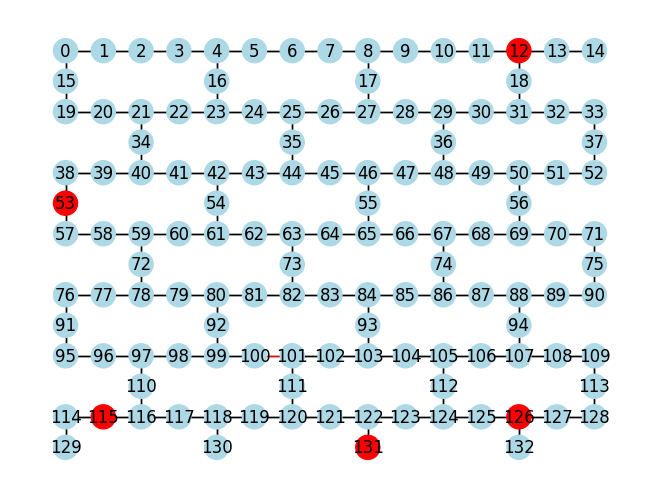

In [23]:
import networkx as nx
def lukes_plot_coupling_map(
    bad_qubits = None, 
    bad_gates = None, 
    highlight_nodes = None, 
    service = service, 
    backend_name = 'ibm_torino'
    ):
  backend = service.backend(backend_name)

  path_colors = ['pink', 'green', 'lilac', 'orange']
  
  pos_dict = {i: [x, -y] for i, (x, y) in enumerate(backend.configuration().coords)}
  edges = backend.configuration().coupling_map
  G = nx.Graph()
  G.add_edges_from(edges)

  qubit_colors = {node: 'lightblue' for node in list(G.nodes())}
  edge_colors = {edge: 'black' for edge in list(G.edges())}

  if bad_qubits is not None:
    for qubit in bad_qubits:
      qubit_colors[qubit] = 'red'
  if bad_gates is not None:
    for edge in bad_gates:
      edge_colors[edge] = 'red'

  if highlight_nodes is not None:
    if type(highlight_nodes[0]) == list:
      for i, highlight_list in enumerate(highlight_nodes):
        for node in highlight_list:
          qubit_colors[node] = path_colors[i%len(path_colors)]
    else:
      for node in highlight_nodes:
        qubit_colors[node] = 'pink'

  nx.draw(G, pos = pos_dict, with_labels = True, node_color = [qubit_colors[node] for node in G.nodes()], node_size = 300)
  nx.draw_networkx_edges(G, pos = pos_dict, edge_color = [edge_colors[edge] for edge in G.edges()])

# Usage
bad_readout_qubits= [12, 53, 115, 126, 131]
bad_czgate_edges =  [(100, 101), (101, 100)]

lukes_plot_coupling_map(bad_qubits = bad_readout_qubits, bad_gates = bad_czgate_edges)

In [24]:
# select the initial layout
# must contain 6 ancillary qubits, 26 spin a, 26 spin b = 58
# ---- TODO : Task 4 ---
spin_a_layout = [0, 15, 19, 20, 21, 34, 40, 41, 42, 54, 61, 62, 63, 73, 82, 83, 84, 93, 103, 104, 105, 112, 124, 123, 122, 121]
spin_b_layout = [2, 3, 4, 16, 23, 24, 25, 35, 44, 45, 46, 55, 65, 66, 67, 74, 86, 87, 88, 94, 107, 108, 109, 113, 128, 127]
# --- End of TODO ---
initial_layout = spin_a_layout + spin_b_layout

In [25]:
# Submit your answer using following code

grade_lab3_ex4(initial_layout) # Expected result type: lists

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [12]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

n_reps = 1
# ---- TODO : Task 5 ---
alpha_alpha_indices = []
for p in range(num_orbitals-2):
    alpha_alpha_indices.append((p,p+1))
alpha_alpha_indices.append((num_orbitals-2,num_orbitals-1))
for p in range(num_orbitals-2):
    alpha_alpha_indices.append((p,p+2))

# --- End of TODO ---
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")

circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
circuit.decompose().decompose().draw("mpl", fold=-1)

E(CCSD) = -109.2177884185543  E_corr = -0.2879500329450033


In [13]:
# Submit your answer using following code

grade_lab3_ex5(alpha_alpha_indices) # Expected result type: list[tuple[int, int]]

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [14]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2093 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1439 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 691 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 383 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 133 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 1 participants have completed this lab
